In [ ]:
# Install dependencies
! pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import preprocessing

In [ ]:
# Datasets locations
tweets_clean_file = '/content/Bitcoin_tweets_clean.csv'
bitcoin_price_file = '/content/BTC-USD.csv'

In [ ]:
# Load cleaned dataset
df_clean = pd.read_csv(tweets_clean_file)

In [ ]:
# Visualize the first 5 elements
df_clean.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,2989762,Viktor Trokhymenko,NaN,I am from Ukraine interested in different dire...,2021-09-10 13:28:14,94.0,270.0,141.0,False,2022-04-19 18:36:25,"Check it out who followed to in Twitter!\n\n, ...","['BTC', 'crypto']",Twitter Web App,False
1,2441888,Crypto dog,NaN,"Market analysis & recaps, scalping leverage ca...",2021-12-20 06:16:13,139.0,221.0,53.0,False,2022-03-19 16:42:19,the strongest bullish signal flashed for Bitco...,"['Bitcoin', 'BTC', 'Cryptocurrency']",Twitter for Android,False
2,835342,Bitcoin,NaN,#bitcoin,2021-03-24 17:33:57,119.0,0.0,0.0,False,2021-08-06 04:03:53,"The current price of bitcoin is $40,149.00. It...","['bitcoin', 'btc', 'cryptocurrency']",Bitcoin Observer,False
3,1245465,Crypto Mentor,NOT FINANCIAL ADVICE,#Bitcoin (Free Crypto Signals🚀)\n14fsw2pR4u942...,2021-02-17 10:28:09,578.0,443.0,1957.0,False,2021-10-19 19:08:53,"Bitcoin going to $64,000 🚀",['Bitcoin'],Twitter for Android,False
4,2377391,AdamLiu,NaN,Crypto Asset Trend Professional Analyst，Early ...,2021-11-24 18:07:05,17714.0,53.0,840.0,False,2022-03-10 03:42:46,bitcoinnews 's short-term decline gives us a c...,"['bitcoinnews', 'BTC', 'BTCUSD', 'bitcon', 'Cr...",Twitter Web App,False


In [ ]:
# Analyze the compound
analyzer = SentimentIntensityAnalyzer()
compound = []
for i, s in enumerate(df_clean['text']):
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound

In [ ]:
# Visualize the first 2 elements
df_clean.head(2)

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,2989762,Viktor Trokhymenko,NaN,I am from Ukraine interested in different dire...,2021-09-10 13:28:14,94.0,270.0,141.0,False,2022-04-19 18:36:25,"Check it out who followed to in Twitter!\n\n, ...","['BTC', 'crypto']",Twitter Web App,False,-0.5067
1,2441888,Crypto dog,NaN,"Market analysis & recaps, scalping leverage ca...",2021-12-20 06:16:13,139.0,221.0,53.0,False,2022-03-19 16:42:19,the strongest bullish signal flashed for Bitco...,"['Bitcoin', 'BTC', 'Cryptocurrency']",Twitter for Android,False,0.9215


In [ ]:
# Calculate the scores based on the influence
scores = []
for i, s in df_clean.iterrows():
    try:
        score = s["compound"] * int(s["user_followers"]) 
        score *= ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) 
        score *= (int(s["is_retweet"])+1)
        scores.append(score)
    except:
        scores.append(np.nan)
df_clean["score"] = scores

In [ ]:
# Visualize the first 2 elements
df_clean.head(2)

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,2989762,Viktor Trokhymenko,NaN,I am from Ukraine interested in different dire...,2021-09-10 13:28:14,94.0,270.0,141.0,False,2022-04-19 18:36:25,"Check it out who followed to in Twitter!\n\n, ...","['BTC', 'crypto']",Twitter Web App,False,-0.5067,-71.194017
1,2441888,Crypto dog,NaN,"Market analysis & recaps, scalping leverage ca...",2021-12-20 06:16:13,139.0,221.0,53.0,False,2022-03-19 16:42:19,the strongest bullish signal flashed for Bitco...,"['Bitcoin', 'BTC', 'Cryptocurrency']",Twitter for Android,False,0.9215,49.405564


In [ ]:
# Load the bitcoin price history
df_price = pd.read_csv(bitcoin_price_file)
df_price.Date = pd.to_datetime(df_price.Date)

In [ ]:
# Visualize the first 2 elements
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


In [ ]:
# Clean from duplicates and group by date (hours) the tweets
df_clean = df_clean.drop_duplicates()
tweets = df_clean.copy()

tweets['date'] = pd.to_datetime(tweets['date'], utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']
tweets_grouped = tweets.resample('1h').sum()

In [ ]:
# Display the new groups
tweets_grouped

,user_followers,user_friends,user_favourites,compound,score
date,,,,,
2021-02-05 11:00:00,408.0,376.0,2244.0,0.0000,0.000000
2021-02-05 12:00:00,0.0,0.0,0.0,0.0000,0.000000
2021-02-05 13:00:00,678.0,744.0,37.0,0.5411,20.531518
2021-02-05 14:00:00,0.0,0.0,0.0,0.0000,0.000000
2021-02-05 15:00:00,0.0,0.0,0.0,0.0000,0.000000
...,...,...,...,...,...
2022-05-13 19:00:00,41235.0,17685.0,70400.0,6.3355,-10052.250876
2022-05-13 20:00:00,3870.0,3127.0,107561.0,0.4472,29311.390531
2022-05-13 21:00:00,24133.0,18033.0,166152.0,3.8510,28940.438480


In [ ]:
# Group by date (hours) the prices
crypto_usd = df_price.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

In [ ]:
# Display the new groups
crypto_usd_grouped

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2022-01-24    36654.328125
2022-01-25    36954.003906
2022-01-26    36852.121094
2022-01-27    37138.234375
2022-01-28    36435.585938
Freq: D, Name: Close, Length: 2691, dtype: float64

In [ ]:
# Create a function that gets the correlation between posts
def get_correlation_score(data_x, data_y, lag=0, method="pearson"):
    return data_x.corrwith(data_y.shift(lag), method=method)['score']

In [ ]:
# Filter the data by getting the correlated dates
beg = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beg:end]
crypto_usd_grouped = crypto_usd_grouped[beg:end]

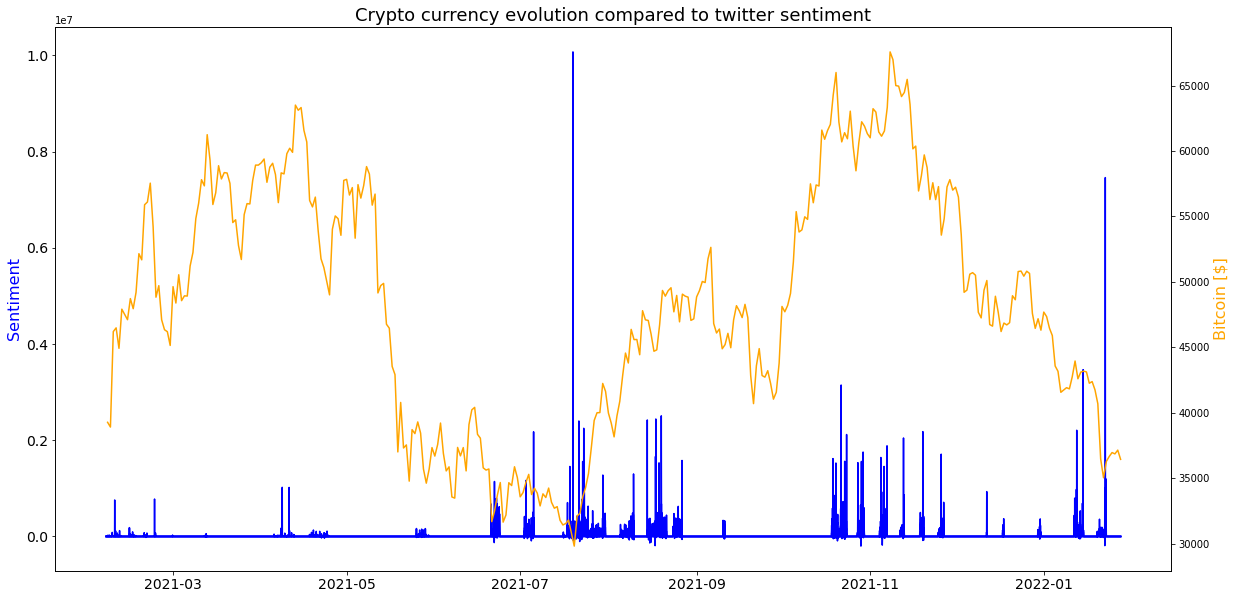

In [ ]:
# Plots the actual data
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'k-', color='blue')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'r-', color='orange')

ax1.set_ylabel("Sentiment", color='blue', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='orange', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


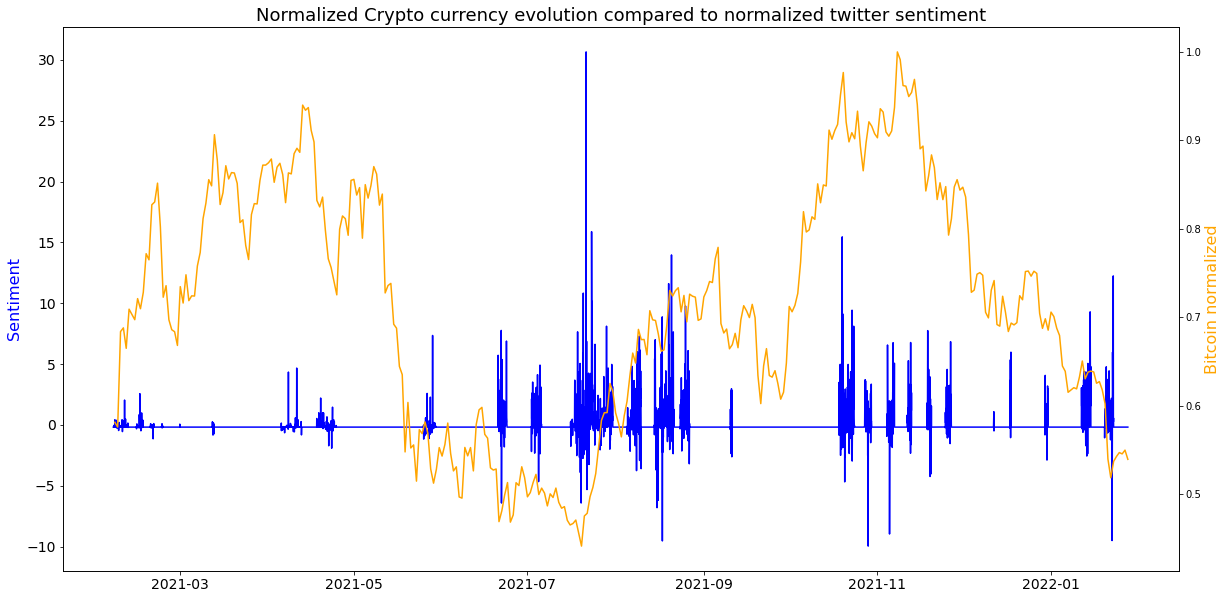

In [ ]:
#Normalize the graph

#Scaling the data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

#Plotting the normalized graph
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-', color='blue')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-', color='orange')

ax1.set_ylabel("Sentiment", color='blue', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='orange', fontsize=16)
plt.show()

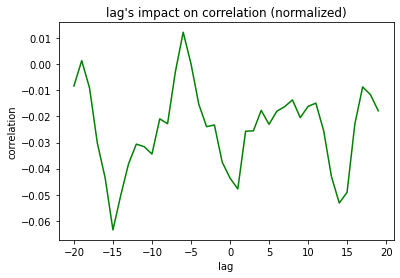

In [ ]:
# Trying to get a correlation between the two with a small lag
correlation = [get_correlation_score(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), correlation, color='green')
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [ ]:
# Get the derivative ofthe two dataframes
tweets_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

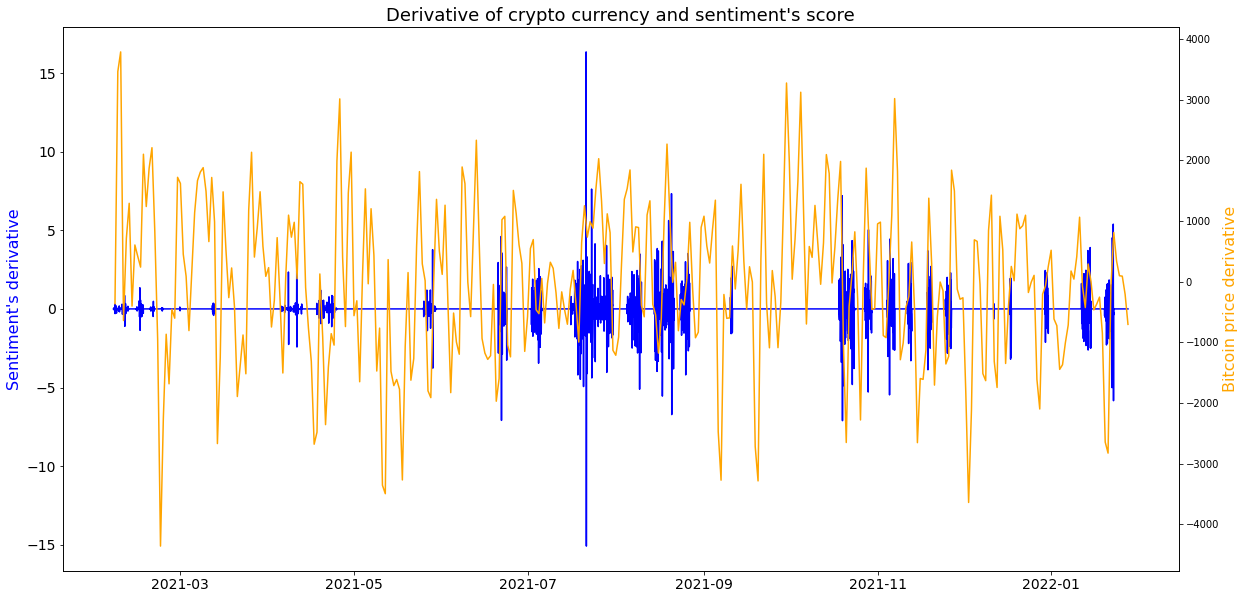

In [ ]:
#Plot the two derivtive
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_derivative.index, tweets_derivative, 'g-', color='blue')
ax2.plot_date(crypto_usd_derivative.index, crypto_usd_derivative, 'b-', color='orange')

ax1.set_ylabel("Sentiment's derivative", color='blue', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='orange', fontsize=16)
plt.show()

In [ ]:
# NLP Analysis

In [ ]:
#Install dependencies
! pip install textblob 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Get the text from the tweets
from textblob import TextBlob

df = df_clean.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,"Check it out who followed to in Twitter!\n\n, ..."
1,the strongest bullish signal flashed for Bitco...
2,"The current price of bitcoin is $40,149.00. It..."
3,"Bitcoin going to $64,000 🚀"
4,bitcoinnews 's short-term decline gives us a c...


In [ ]:
# Getting the stopwords
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
stop_words = nltk.corpus.stopwords.words(['english'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [ ]:
# Create a text cleaning function
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()

def cleaning(txt):
    # Remove urls
    tweet_without_url = re.sub(r'http\S+',' ', txt)
    # Remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)
    # Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)
    # Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)
    # Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]
    # Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    # Lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]
    # Joining
    return " ".join(text_cleaned)

In [ ]:
# Clean the datas
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()

,tweets,cleaned_tweets,date_clean
0,"Check it out who followed to in Twitter!\n\n, ...",Check followed Twitter many Twitter Score sgm ...,2022-04-19
1,the strongest bullish signal flashed for Bitco...,strongest bullish signal flashed Bitcoin Not t...,2022-03-19
2,"The current price of bitcoin is $40,149.00. It...",The current price bitcoin It increased last ho...,2021-08-06
3,"Bitcoin going to $64,000 🚀",Bitcoin going,2021-10-19
4,bitcoinnews 's short-term decline gives us a c...,bitcoinnews short term decline give u chance l...,2022-03-10


In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

In [ ]:
# Create a function to get the polarity
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [ ]:
# Create a function that evaluate the scores
def eval_score(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    return 'positive'

In [ ]:
# Create a function that observe the sentiment in a period
def observe_period(period):
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    res = res.apply(eval_score)
    return res

In [ ]:
# Analyze the crypto sentiment week by week
time_sentiment = observe_period(7) # compare price ratio in 7 days. price_7_days_later/ price_now 
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [ ]:
# Get the subjectivity and polarity of the tweets
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,"Check it out who followed to in Twitter!\n\n, ...",Check followed Twitter many Twitter Score sgm ...,2022-04-19,NaN,0.500000,0.50
1,the strongest bullish signal flashed for Bitco...,strongest bullish signal flashed Bitcoin Not t...,2022-03-19,NaN,0.545833,0.20
2,"The current price of bitcoin is $40,149.00. It...",The current price bitcoin It increased last ho...,2021-08-06,negative,0.233333,0.00
3,"Bitcoin going to $64,000 🚀",Bitcoin going,2021-10-19,negative,0.000000,0.00
4,bitcoinnews 's short-term decline gives us a c...,bitcoinnews short term decline give u chance l...,2022-03-10,NaN,0.425000,0.15


In [ ]:
# Create a function that gets the sentiment
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    return 'positive'

In [ ]:
# Gets the sentiment
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,"Check it out who followed to in Twitter!\n\n, ...",Check followed Twitter many Twitter Score sgm ...,2022-04-19,NaN,0.500000,0.50,positive,False
1,the strongest bullish signal flashed for Bitco...,strongest bullish signal flashed Bitcoin Not t...,2022-03-19,NaN,0.545833,0.20,positive,False
2,"The current price of bitcoin is $40,149.00. It...",The current price bitcoin It increased last ho...,2021-08-06,negative,0.233333,0.00,neutral,False
3,"Bitcoin going to $64,000 🚀",Bitcoin going,2021-10-19,negative,0.000000,0.00,neutral,False
4,bitcoinnews 's short-term decline gives us a c...,bitcoinnews short term decline give u chance l...,2022-03-10,NaN,0.425000,0.15,positive,False


In [ ]:
# Save to file
df.to_csv('/content/df_data.csv')

In [ ]:
# Model Preparation

In [ ]:
# Import the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,"Check it out who followed to in Twitter!\n\n, ...",Check followed Twitter many Twitter Score sgm ...,2022-04-19,NaN,0.500000,0.50,positive,False
1,the strongest bullish signal flashed for Bitco...,strongest bullish signal flashed Bitcoin Not t...,2022-03-19,NaN,0.545833,0.20,positive,False
2,"The current price of bitcoin is $40,149.00. It...",The current price bitcoin It increased last ho...,2021-08-06,negative,0.233333,0.00,neutral,False
3,"Bitcoin going to $64,000 🚀",Bitcoin going,2021-10-19,negative,0.000000,0.00,neutral,False
4,bitcoinnews 's short-term decline gives us a c...,bitcoinnews short term decline give u chance l...,2022-03-10,NaN,0.425000,0.15,positive,False


In [ ]:
# Prepare the datas for the train
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [ ]:
# Split the data
seed = 38 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26422,) (6606,) (26422, 3) (6606, 3)


In [ ]:
# Tokenize inputs
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Convert the inputs into limited (30 words) sequences
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(26422, 30) (6606, 30)


In [ ]:
# Compile the NN
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

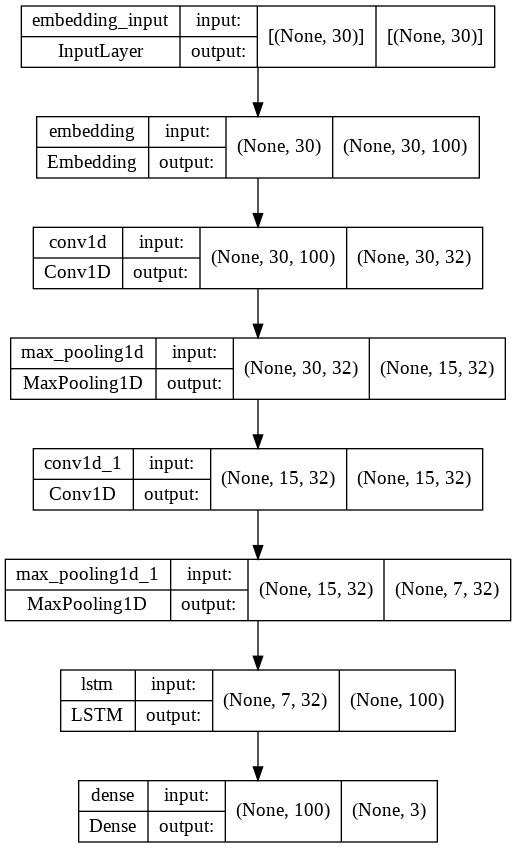

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
207/207 - 18s - loss: 0.5504 - accuracy: 0.7854 - val_loss: 0.3613 - val_accuracy: 0.8747 - 18s/epoch - 86ms/step
Epoch 2/10
207/207 - 13s - loss: 0.1901 - accuracy: 0.9380 - val_loss: 0.2199 - val_accuracy: 0.9302 - 13s/epoch - 61ms/step
Epoch 3/10
207/207 - 14s - loss: 0.0680 - accuracy: 0.9808 - val_loss: 0.2157 - val_accuracy: 0.9379 - 14s/epoch - 67ms/step
Epoch 4/10
207/207 - 13s - loss: 0.0360 - accuracy: 0.9902 - val_loss: 0.2280 - val_accuracy: 0.9407 - 13s/epoch - 61ms/step
Epoch 5/10
207/207 - 13s - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.2303 - val_accuracy: 0.9423 - 13s/epoch - 62ms/step
Epoch 6/10
207/207 - 13s - loss: 0.0184 - accuracy: 0.9954 - val_loss: 0.2557 - val_accuracy: 0.9348 - 13s/epoch - 61ms/step
Epoch 7/10
207/207 - 14s - loss: 0.0155 - accuracy: 0.9959 - val_loss: 0.2676 - val_accuracy: 0.9435 - 14s/epoch - 66ms/step
Epoch 8/10
207/207 - 13s - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.3208 - val_accuracy: 0.9405 - 13s/epoch - 61ms/step


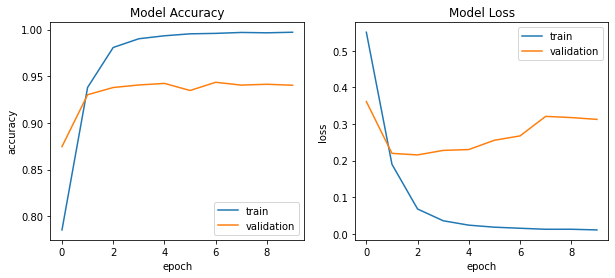

In [ ]:
# Plot the trained data
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [ ]:
# Get the accuracy
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	94.0%
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       710
           1       0.95      0.95      0.95      2630
           2       0.94      0.97      0.96      3266

    accuracy                           0.94      6606
   macro avg       0.92      0.89      0.91      6606
weighted avg       0.94      0.94      0.94      6606



2    3266
1    2630
0     710
dtype: int64
2    3374
1    2619
0     613
dtype: int64


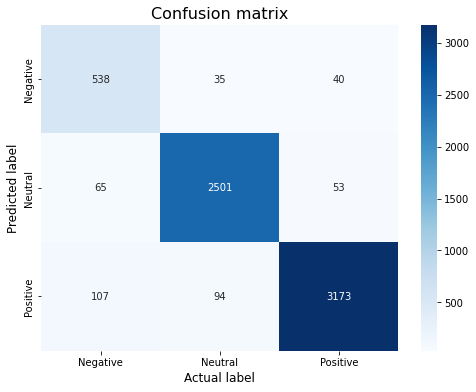

In [ ]:
# Plot the confusion matrix of the actual and predicted data
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
# Model 2

In [ ]:
# Tokenize and turn into sequence the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 Check followed Twitter many Twitter Score sgm NDPCjW BTC crypto via
After Tokenization & Padding 
 [  98 1664  196  208  196 1037    2    3  159    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
# Prepare the data to train
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (19816, 50) (19816, 3)
Validation Set:  (6606, 50) (6606, 3)
Test Set:  (6606, 50) (6606, 3)


In [ ]:
# Create a function that evaluates the score
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# Import the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
# Set the parameters
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
# Build the NN model
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

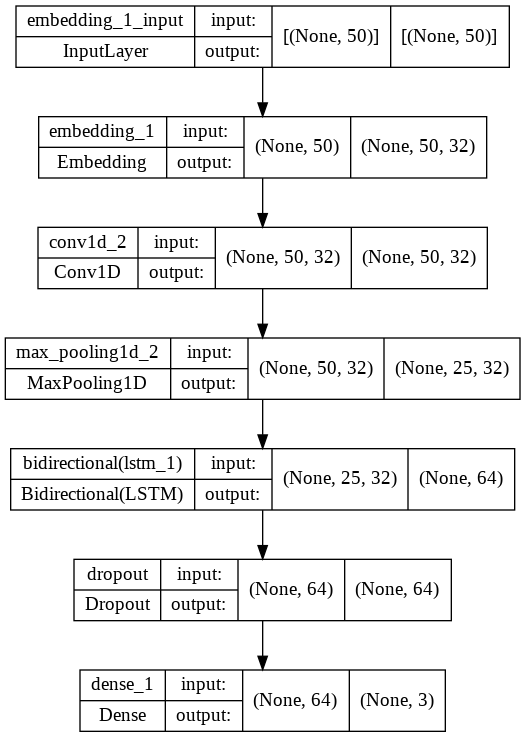

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/10
155/155 [==============================] - 14s 51ms/step - loss: 0.9691 - accuracy: 0.4944 - precision: 0.5230 - recall: 0.1527 - val_loss: 0.9428 - val_accuracy: 0.4967 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
155/155 [==============================] - 6s 41ms/step - loss: 0.9442 - accuracy: 0.5291 - precision: 0.5811 - recall: 0.2422 - val_loss: 0.9249 - val_accuracy: 0.5607 - val_precision: 0.6363 - val_recall: 0.3318
Epoch 3/10
155/155 [==============================] - 7s 46ms/step - loss: 0.9168 - accuracy: 0.5798 - precision: 0.6326 - recall: 0.3863 - val_loss: 0.8911 - val_accuracy: 0.5975 - val_precision: 0.6439 - val_recall: 0.4718
Epoch 4/10
155/155 [==============================] - 6s 42ms/step - loss: 0.8959 - accuracy: 0.5994 - precision: 0.6334 - recall: 0.4816 - val_loss: 0.8811 - val_accuracy: 0.6061 - val_precision: 0.6308 - val_recall: 0.5082
Epoch 5/10
155/155 [==============================] - 7s 43ms/step - loss: 0.8885 - accurac

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Accuracy  : 0.6385
Precision : 0.6781
Recall    : 0.5481
F1 Score  : 0.6062


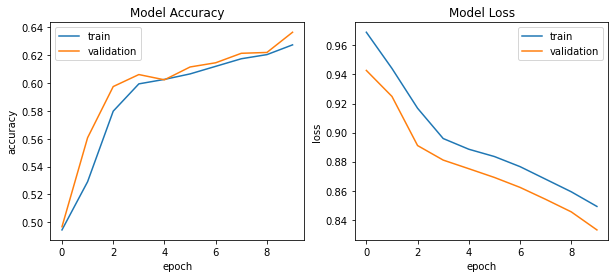

In [ ]:
plot_training_hist(history)

2    3283
1    2622
0     701
dtype: int64
2    3942
1    2664
dtype: int64


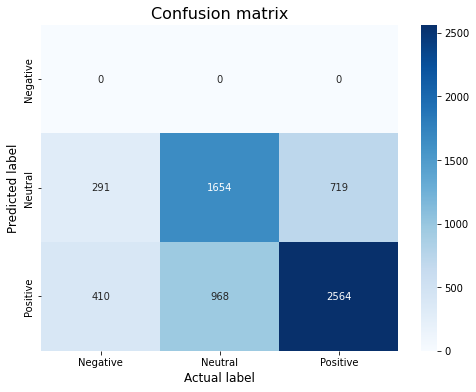

In [ ]:
plot_confusion_matrix(model, X_test, y_test)